In [1]:
pip install pyspark_dist_explore

In [2]:
pip install pyspark

     |████████████████████████████████| 281.3 MB 41 kB/s 
     |████████████████████████████████| 198 kB 60.8 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.0-py2.py3-none-any.whl size=281805912 sha256=cedea35b20be21ad87be79c66d85a1b79021981c07cc09544af60653d18d851c
  Stored in directory: /root/.cache/pip/wheels/0b/de/d2/9be5d59d7331c6c2a7c1b6d1a4f463ce107332b1ecd4e80718
Successfully built pyspark


In [28]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField,StringType,IntegerType
from pyspark.sql.functions import desc
from pyspark.sql.functions import countDistinct
from pyspark_dist_explore import hist
import matplotlib.pyplot as plt
from pyspark.sql import Row
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
import numpy as np
import pandas as pd

In [4]:
spark = SparkSession.builder.appName('BDA proj').getOrCreate()
sc = spark.sparkContext

schema = StructType([StructField('Animetitle', StringType(), True),
                     StructField('Username', StringType(), True),
                     StructField('Rating', IntegerType(), True)])

In [5]:
df = spark.read.csv('CF Data.csv',schema=schema,header=True)
df.printSchema()

root
 |-- Animetitle: string (nullable = true)
 |-- Username: string (nullable = true)
 |-- Rating: integer (nullable = true)



In [ ]:
df.describe().show()

+-------+--------------------+-----------+------------------+
|summary|          Animetitle|   Username|            Rating|
+-------+--------------------+-----------+------------------+
|  count|               85877|      85877|             85877|
|   mean|                null|   Infinity|7.4330146605028125|
| stddev|                null|        NaN|2.1740434905761257|
|    min|"""Bungaku Shoujo...|---was-----|                 1|
|    max|   xxxHOLiC Shunmuki|   zzzjynne|                10|
+-------+--------------------+-----------+------------------+



#Data Pre-processing

In [6]:
#drop missing value
df=df.na.drop()

In [ ]:
df.where("Animetitle is Null").show()
df.where("Username is Null").show()
df.where("Rating is Null").show()
#no missing value in the table

+----------+--------+------+
|Animetitle|Username|Rating|
+----------+--------+------+
+----------+--------+------+

+----------+--------+------+
|Animetitle|Username|Rating|
+----------+--------+------+
+----------+--------+------+

+----------+--------+------+
|Animetitle|Username|Rating|
+----------+--------+------+
+----------+--------+------+



In [ ]:
df.groupBy("Animetitle",'Username','Rating').count().filter("count > 1").show()
#dulicated values exist in the table

+--------------------+---------------+------+-----+
|          Animetitle|       Username|Rating|count|
+--------------------+---------------+------+-----+
|Neon Genesis Evan...|      SNKFanboy|     1|    2|
|     Kimi to Boku. 2|     Konomi1017|     8|    2|
|   Acchi Kocchi (TV)|     Romie-chan|     7|    2|
|Shingeki no Kyoji...|      PyraXadon|     7|    2|
|Love Live! School...|    Micsupreeme|     7|    2|
|Shingeki no Kyoji...|     LegendAqua|     9|    2|
|JoJo no Kimyou na...|GodLikesMudkips|    10|    2|
|Eizouken ni wa Te...|    Cloudflight|     8|    2|
|     Detective Conan|     Meitanteii|     9|    2|
|          Elfen Lied|Fear_the_Reefer|     5|    2|
|Otome Game no Ham...|  SaintJames012|     7|    2|
|       Munou na Nana|    MehMcBoored|     7|    2|
|Baka to Test to S...|    sen_mcgrath|     8|    2|
|    Kuroko no Basket|     AbsarNaeem|     9|    2|
| Himouto! Umaru-chan|danny_dominguez|     3|    2|
|Log Horizon 2nd S...|    Eagleshadow|     5|    2|
|Baka to Tes

In [7]:
df=df.dropDuplicates(["Animetitle",'Username','Rating'])
df.groupBy("Animetitle",'Username','Rating').count().filter("count > 1").show()
#delete all duplicated value in the table

+----------+--------+------+-----+
|Animetitle|Username|Rating|count|
+----------+--------+------+-----+
+----------+--------+------+-----+



#Descriptive Analysis

In [ ]:
#there are 4313 distinct animes, and most reviewed animes have 80 ratings
#averagely each anime has 20 rating
df.groupBy("Animetitle").count().sort(desc("count")).show(8)
df.select(countDistinct("Animetitle")).show()

+--------------------+-----+
|          Animetitle|count|
+--------------------+-----+
|      Kimi no Na wa.|   80|
|Rainbow: Nisha Ro...|   80|
|Mahouka Koukou no...|   80|
|       Steins;Gate 0|   80|
|Kono Subarashii S...|   80|
|Little Witch Acad...|   80|
|         Golden Time|   80|
|Love Live! School...|   80|
+--------------------+-----+
only showing top 8 rows

+--------------------------+
|count(DISTINCT Animetitle)|
+--------------------------+
|                      4313|
+--------------------------+



In [ ]:
#there are 35091 distinct animes, and most review-giving users give 492 ratings
#so if we use CF, it's a better choice to use item-based CF because item is far fewer than user  
#on average each user give 2.3 rating
#suspect most users only give 1 rating
df.groupBy("Username").count().sort(desc("count")).show(8)
df.select(countDistinct("Username")).show()

+--------------+-----+
|      Username|count|
+--------------+-----+
|      Stark700|  492|
|      ktulu007|  399|
|    LegendAqua|  322|
|   ggultra2764|  298|
|     PyraXadon|  248|
|  BanjoTheBear|  234|
|literaturenerd|  214|
|  angelsreview|  177|
+--------------+-----+
only showing top 8 rows

+------------------------+
|count(DISTINCT Username)|
+------------------------+
|                   35091|
+------------------------+



In [ ]:
#rating range is 1-10, the most given rating is 8, mean is 7.4
df.groupBy("Rating").count().sort(desc("count")).show()
df.select(countDistinct("Rating")).show()

+------+-----+
|Rating|count|
+------+-----+
|     8|17313|
|     9|16911|
|    10|15049|
|     7|13087|
|     6| 8023|
|     5| 5563|
|     4| 3710|
|     3| 3403|
|     2| 1577|
|     1| 1221|
+------+-----+

+----------------------+
|count(DISTINCT Rating)|
+----------------------+
|                    10|
+----------------------+



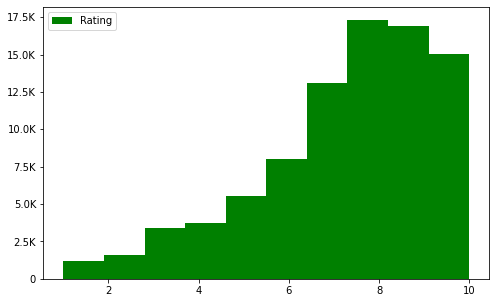

In [8]:
#see distribution of rating
#left skewed distribution with more higher rating
fig, ax = plt.subplots()
fig.set_size_inches(8, 5) 
hist(ax, df.select('Rating'), color=['green'])
ax.legend()

#Subsample data

In [ ]:
#data fill rate is 0.056%,data sparsity is high
#try to use subsample to filter out only the popular anime and active user
df.createOrReplaceTempView("df_filtered")
df1=spark.sql("""select * from df_filtered where Animetitle in (select Animetitle from df_filtered group By Animetitle having count(*)>4)""")
#df1.select(countDistinct("Animetitle")).show()
df1.show()

+--------------------+----------------+------+
|          Animetitle|        Username|Rating|
+--------------------+----------------+------+
|Hai to Gensou no ...|    netosolano98|     8|
|Hai to Gensou no ...|   mikomi_nakama|     4|
|           Working!!|     BentoLegend|     8|
|  Tsurezure Children|    SirMarmelady|     4|
|  Aria the Animation|      XanWasting|     5|
|       Fruits Basket|     101swoop101|    10|
|       Fruits Basket|    angelsreview|     6|
|Kenpuu Denki Berserk|            jdbe|    10|
|     Mousou Dairinin|      HiGHFLYiN9|    10|
|            Nichijou|       myronator|     8|
|Sword Art Online ...|        Kyojin-x|     9|
|      Urusei Yatsura|middleground4471|    10|
|Break Blade 1: Ka...|        mel-hime|    10|
|Naruto: Shippuude...|       ao_no_exo|    10|
| AKB0048: Next Stage| DevilishAngel86|     7|
|              Blood+|Okazaki-Fragment|    10|
|              Blood+|          itaeon|     9|
|Cardcaptor Sakura...|     PokeFan2112|     7|
|       Chrno

In [ ]:
df1.createOrReplaceTempView("df_filtered1")
df2=spark.sql("""select * from df_filtered1 where Username in (select Username from df_filtered1 group By Username having count(*)>4)""")
df2.select(countDistinct("Username")).show()
df2.select(countDistinct("Animetitle")).show()

+------------------------+
|count(DISTINCT Username)|
+------------------------+
|                    3038|
+------------------------+

+--------------------------+
|count(DISTINCT Animetitle)|
+--------------------------+
|                      2626|
+--------------------------+



In [9]:
#we meet some problems when trying to use df2 to build model
#so we choose another way: convert to dataframe then select
df=df.toPandas()

In [10]:
popular_items = df['Animetitle'].value_counts()>4
popular_items = popular_items[popular_items].index.tolist()
active_users = df['Username'].value_counts() >4
active_users = active_users[active_users].index.tolist() # get list of active users
df = df[(df['Animetitle'].isin(popular_items)) & (df['Username'].isin(active_users))]

In [ ]:
df['Animetitle'].nunique()

2031

In [ ]:
df['Username'].nunique()

3038

In [11]:
df2 = spark.createDataFrame(df)

In [ ]:
df2.describe().show()

+-------+--------------------+--------+------------------+
|summary|          Animetitle|Username|            Rating|
+-------+--------------------+--------+------------------+
|  count|               36031|   36031|             36031|
|   mean|                null|Infinity| 7.293247481335516|
| stddev|                null|     NaN|2.0662732324436694|
|    min|"""Bungaku Shoujo...| -Elina-|                 1|
|    max|        xxxHOLiC Kei|   zztl9|                10|
+-------+--------------------+--------+------------------+



#Building recommender system using pyspark MF and ALS method

In [12]:
#we need to convert userid and itemid to numeric to facilitate matrix indexing.
userids = np.sort([x.Username for x in df2.select("Username").distinct().collect()])
userid_encode = {x: i for i, x in enumerate(userids)}
itemids = np.sort([x.Animetitle for x in df2.select("Animetitle").distinct().collect()])
itemid_encode = {x: i for i, x in enumerate(itemids)}
print(len(userids), len(itemids))

3163 2629


In [13]:
newcolnames = ['itemid','userid','rating']
rdd=df2.rdd.map(lambda x: (itemid_encode[x[0]],userid_encode[x[1]],float(x[2])))
df3 = rdd.toDF()
for c,n in zip(df3.columns,newcolnames):
    df3=df3.withColumnRenamed(c,n)
df3.show(10)

+------+------+------+
|itemid|userid|rating|
+------+------+------+
|   824|  2785|   8.0|
|  2510|   262|   8.0|
|  2423|  1740|   4.0|
|   149|  2090|   5.0|
|   653|    17|  10.0|
|   653|  2214|   6.0|
|  1189|  2574|  10.0|
|  1603|   785|  10.0|
|  1691|  2769|   8.0|
|  2268|  1024|   9.0|
+------+------+------+
only showing top 10 rows



In [20]:
# split data into training and test sets 
(training, test) = df3.randomSplit([0.8, 0.2])
print("trainset=",training.count(), "test set=", test.count())

trainset= 30562 test set= 7616


In [21]:
als = ALS(maxIter=20, rank=15, regParam=0.01, userCol="userid", itemCol="itemid", ratingCol="rating", coldStartStrategy="drop", implicitPrefs=False)
model = als.fit(training)

In [22]:
# Evaluate the model by computing the MAE (or RMSE) on the test data
# (try comparing the performance treating the data as explicit ratings versus implicit ratings)
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName="mae", labelCol="rating", predictionCol="prediction")
error = evaluator.evaluate(predictions)
print("Mean Absolute error = ", error)
#for rating range 1-10, before subsample,MAE is 3.24
#after subsample,MAE drop to 2.53

Mean Absolute error =  2.6861181715947526


In [34]:
# Generate top 2 Anime recommendations for each user
userRecs = model.recommendForAllUsers(3)
userRecs.show(10)
# Generate top 2 user recommendations for each anime
animeRecs = model.recommendForAllItems(2)
animeRecs.show(10)

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


+------+--------------------+
|userid|     recommendations|
+------+--------------------+
|     1|[{2208, 14.131914...|
|     3|[{2480, 13.295465...|
|     5|[{1312, 10.001163...|
|     6|[{1332, 11.792203...|
|     9|[{2595, 11.671766...|
|    12|[{2159, 12.262802...|
|    13|[{1066, 12.869434...|
|    15|[{761, 11.348384}...|
|    16|[{537, 11.058506}...|
|    17|[{415, 11.539774}...|
+------+--------------------+
only showing top 10 rows

+------+--------------------+
|itemid|     recommendations|
+------+--------------------+
|     1|[{3037, 12.503757...|
|     3|[{2364, 11.429666...|
|     5|[{1759, 13.230789...|
|     6|[{2598, 9.988437}...|
|     9|[{2828, 8.013608}...|
|    12|[{2075, 12.921648...|
|    13|[{2598, 9.847462}...|
|    15|[{1722, 8.9886265...|
|    16|[{2973, 16.178156...|
|    17|[{2973, 15.296373...|
+------+--------------------+
only showing top 10 rows



In [35]:
#for a specific user show the recommendations
userRecs.select('Userid','recommendations').where('userid=888').show(truncate=False)

+------+-------------------------------------------------------+
|Userid|recommendations                                        |
+------+-------------------------------------------------------+
|888   |[{2310, 13.370332}, {393, 11.19603}, {1848, 11.014552}]|
+------+-------------------------------------------------------+



In [25]:
#for a specific item show the likely users
animeRecs.select('itemid','recommendations').where('itemid=666').show(truncate=False)

+------+--------------------------------------+
|itemid|recommendations                       |
+------+--------------------------------------+
|666   |[{1291, 13.215325}, {1778, 12.832084}]|
+------+--------------------------------------+



In [26]:
def searchKeysByVal(dict, byVal):
    keysList = []
    itemsList = dict.items()
    for item in itemsList:
        if item[1] == byVal:
            keysList.append(item[0])
    return keysList

In [40]:
user='Stark700'
result=pd.DataFrame(columns=['userid','username','Anime_recommend'])
for i in range(3):
  aa=userRecs.select('recommendations').where('userid=1800').collect()[0][0][i][0]
  result.loc[i,'Anime_recommend']=searchKeysByVal(itemid_encode, aa)
result.loc[:,'username']=user
result.loc[:,'userid']=userid_encode[user]
result

,userid,username,Anime_recommend
0,1800,Stark700,[Shouwa Genroku Rakugo Shinjuu: Sukeroku Futat...
1,1800,Stark700,[Doukyuusei (Movie)]
2,1800,Stark700,[Kaguya-sama wa Kokurasetai: Tensai-tachi no R...
